In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [103]:
# %%
# Load the CDD data
cdd_file = "cddid.tbl.gz"
cdd_df = pd.read_csv(cdd_file, sep="\t", header=None, names=["CDD_ID", "Domain_ID", "Gene_Name", "Description", "Length"])
cdd_df = cdd_df[["Domain_ID","Gene_Name"]]
# View first few rows
print(cdd_df)

        Domain_ID     Gene_Name
0        CHL00001          rpoB
1        CHL00002          matK
2        CHL00003          psbA
3        CHL00004          psbD
4        CHL00005         rps16
...           ...           ...
67155  smart01100   CRAL_TRIO_N
67156  smart01101  CRISPR_assoc
67157  smart01102        CRM1_C
67158  smart01103     CRS1_YhbY
67159  smart01104           CTD

[67160 rows x 2 columns]


In [104]:
superfam_df = pd.read_csv("CDDID_SuperfamilyID.txt", sep='\t')
superfam_df.columns = ["CDD_ID_1", "Accession_1", "CDD_ID_2", "Accession_2"]

superfam_df = superfam_df.drop(columns=[ "Accession_1","Accession_2" ])
# Rename columns for clarity
superfam_df.columns = ["CDD_ID", "Superfamily"]

# Drop duplicates if any
superfam_df = superfam_df.drop_duplicates()
#superfam_df

In [105]:

RNA_seq_df = pd.read_csv("drosophila_rnaseq.txt", sep='\t')
#RNA_seq_df.head(1)

In [106]:
setsub_seq_df = pd.read_csv("SETSubfamilies(1).txt", delim_whitespace=True)
setsub_seq_df.columns = ['CDD_ID', 'Gene_Name', 'Subfamily_CDDID',"Subfamily_Name"]

#setsub_seq_df[['CDD_ID','Gene_ID','Subfamily_CDDID']] =setsub_seq_df["CDD_ID Gene Name Subfamily CDD_ID"].str.split(r"\s+", n=1, expand=True)
#setsub_seq_df = setsub_seq_df.drop(columns=["CDD_ID Gene Name   Subfamily CDD_ID"])
print(setsub_seq_df.columns)
setsub_seq_df

Index(['CDD_ID', 'Gene_Name', 'Subfamily_CDDID', 'Subfamily_Name'], dtype='object')


C:\Users\ssali\AppData\Local\Temp\ipykernel_22264\3980075358.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  setsub_seq_df = pd.read_csv("SETSubfamilies(1).txt", delim_whitespace=True)


,CDD_ID,Gene_Name,Subfamily_CDDID,Subfamily_Name
0,cd08161,SET,cd08161,SET
1,cd10518,SETD1-like,cd10518,SETD1-like
2,cd19169,SETD1,cd10518,SETD1-like
3,cd19204,SETD1A,cd10518,SETD1-like
4,cd19205,SETD1B,cd10518,SETD1-like
...,...,...,...,...
81,cd10536,SMYD4,cd20071,SMYD
82,cd19167,SMYD1/2/3-like,cd20071,SMYD
83,cd10526,SMYD1,cd20071,SMYD
84,cd19202,SMYD2,cd20071,SMYD


In [107]:
cddid_df = pd.read_csv("mart_export (1).txt", sep='/t')
cddid_df[['Gene_ID', 'CDD_ID']] = cddid_df["Gene stable ID	CDD ID"].str.split("\t", expand=True)
# Drop the old combined column
cddid_df = cddid_df.drop(columns=["Gene stable ID	CDD ID"])
cddid_df

C:\Users\ssali\AppData\Local\Temp\ipykernel_22264\3224280420.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cddid_df = pd.read_csv("mart_export (1).txt", sep='/t')


,Gene_ID,CDD_ID
0,FBgn0029843,cd08662
1,FBgn0029843,cd08662
2,FBgn0029843,cd08662
3,FBgn0029843,cd08662
4,FBgn0029843,cd08662
...,...,...
132992,FBgn0030673,None
132993,FBgn0030673,None
132994,FBgn0030673,None
132995,FBgn0030673,None


In [108]:
merged_df = cddid_df.merge(superfam_df, on='CDD_ID')
df_merged = merged_df.merge(cdd_df, left_on="Superfamily", right_on="Domain_ID", how="left")

# Append gene names directly to the Superfamily column
df_merged["Superfamily"] = df_merged["Superfamily"] + ": " + df_merged["Gene_Name"]

df_merged.drop(columns=["Domain_ID"], inplace=True)
merged_df=df_merged
print(df_merged)

           Gene_ID   CDD_ID               Superfamily        Gene_Name
0      FBgn0029843  cd08662        cl14813: GluZincin        GluZincin
1      FBgn0029843  cd08662        cl14813: GluZincin        GluZincin
2      FBgn0029843  cd08662        cl14813: GluZincin        GluZincin
3      FBgn0029843  cd08662        cl14813: GluZincin        GluZincin
4      FBgn0029843  cd08662        cl14813: GluZincin        GluZincin
...            ...      ...                       ...              ...
79612  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate
79613  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate
79614  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate
79615  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate
79616  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate

[79617 rows x 4 columns]


In [109]:
final_df = merged_df.merge(RNA_seq_df, left_on="Gene_ID", right_on="GeneID", how="inner")
final_df["CDD_ID"]
print(final_df)
finals_df = final_df.merge(setsub_seq_df,on= "CDD_ID",how="inner")
finals_df.drop(columns=["Superfamily","Gene_Name_x","GeneID"], inplace=True)
finals_df

            Gene_ID   CDD_ID               Superfamily        Gene_Name  \
0       FBgn0029843  cd08662        cl14813: GluZincin        GluZincin   
1       FBgn0029843  cd08662        cl14813: GluZincin        GluZincin   
2       FBgn0029843  cd08662        cl14813: GluZincin        GluZincin   
3       FBgn0029843  cd08662        cl14813: GluZincin        GluZincin   
4       FBgn0029843  cd08662        cl14813: GluZincin        GluZincin   
...             ...      ...                       ...              ...   
724395  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate   
724396  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate   
724397  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate   
724398  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate   
724399  FBgn0085434  cd13433  cd13433: Na_channel_gate  Na_channel_gate   

             GeneID TranscriptID  Sample.00h  Sample.01h  Sample.02h  \
0       FBgn0029843  FBtr00

,Gene_ID,CDD_ID,TranscriptID,Sample.00h,Sample.01h,Sample.02h,Sample.03h,Sample.04h,Sample.05h,Sample.06h,Sample.08h,Sample.10h,Sample.12h,Sample.14h,Sample.16h,Gene_Name_y,Subfamily_CDDID,Subfamily_Name
0,FBgn0086908,cd10517,FBtr0112777,69.253,80.420,106.600,86.367,81.286,58.739,47.960,40.234,26.193,23.638,13.375,15.132,SETDB1,cd10538,SETDB-like
1,FBgn0086908,cd10517,FBtr0112777,69.253,80.420,106.600,86.367,81.286,58.739,47.960,40.234,26.193,23.638,13.375,15.132,SETDB1,cd10538,SETDB-like
2,FBgn0033917,cd20071,FBtr0087536,47.959,48.894,27.817,14.542,13.164,13.012,16.876,25.639,56.026,70.238,72.156,74.606,SMYD,cd20071,SMYD
3,FBgn0033917,cd20071,FBtr0087536,47.959,48.894,27.817,14.542,13.164,13.012,16.876,25.639,56.026,70.238,72.156,74.606,SMYD,cd20071,SMYD
4,FBgn0033917,cd20071,FBtr0087536,47.959,48.894,27.817,14.542,13.164,13.012,16.876,25.639,56.026,70.238,72.156,74.606,SMYD,cd20071,SMYD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,FBgn0033633,cd10536,FBtr0088133,1.231,0.290,1.196,1.156,1.318,1.068,2.872,1.950,8.492,19.110,38.753,40.660,SMYD4,cd20071,SMYD
637,FBgn0033633,cd10536,FBtr0088133,1.231,0.290,1.196,1.156,1.318,1.068,2.872,1.950,8.492,19.110,38.753,40.660,SMYD4,cd20071,SMYD
638,FBgn0037841,cd10544,FBtr0113216,4.130,5.737,6.381,7.902,7.056,7.000,6.333,8.831,5.049,4.585,3.992,3.039,SETMAR,cd10538,SETDB-like
639,FBgn0037841,cd10544,FBtr0113216,4.130,5.737,6.381,7.902,7.056,7.000,6.333,8.831,5.049,4.585,3.992,3.039,SETMAR,cd10538,SETDB-like


In [110]:
# Drop unnecessary columns
Superfamily_Transcript_df = finals_df.drop(columns=['Gene_ID', 'CDD_ID'])

#  Keep all unique Subfamily-TranscriptID combinations
df_unique = Superfamily_Transcript_df.drop_duplicates(subset=["Subfamily_CDDID", "TranscriptID"])
#print(df_unique)
#  Sum TPM values per Subfamily_CDDID, keeping one representative Gene_Name_y
df_summed = df_unique.groupby("Subfamily_CDDID").agg({
    "Subfamily_Name": "first",  # Take one subfamily name per subfamily
    **{col: "sum" for col in df_unique.columns if col not in ["Subfamily_CDDID", "Gene_Name_y", "TranscriptID", "Subfamily_Name"]}
}).reset_index()
#print(df_summed)
output_file = 'unique_TPM_expression_amph_part2.txt'
df_summed.to_csv(output_file, sep='\t', index=False)

# Log2 transform of numeric TPM columns (replace 0s for log-safety)
numeric_cols = df_summed.columns.difference(["Subfamily_CDDID", "Gene_Name_y","Subfamily_Name"])
df_loged = np.log2(df_summed[numeric_cols].replace(0, 0.5) + 0.5)
print(df_summed)
# Add identifiers back to the log dataframe
df_loged["Subfamily_CDDID"] = df_summed["Subfamily_CDDID"]
df_loged["Subfamily_Name"] = df_summed["Subfamily_Name"]

df_loged = df_loged.sort_values(by="Subfamily_Name", ascending=True)
#df_loged.drop(columns=["Gene_Name"], inplace=True)
# Result
df_loged

  Subfamily_CDDID Subfamily_Name  Sample.00h  Sample.01h  Sample.02h  \
0         cd10518     SETD1-like     110.143     135.022     111.007   
1         cd10519            EZH      59.060      39.276       6.421   
2         cd10527           LSMT     115.425     111.948      48.105   
3         cd10528          SETD8     172.920     187.669      95.988   
4         cd10529     SETD5-like      60.550     107.486      92.594   
5         cd10531     SETD2-like     273.183     285.807     144.101   
6         cd10534      PRDM-like       1.887       0.575       2.044   
7         cd10538     SETDB-like     246.857     264.152     177.059   
8         cd20071           SMYD     181.871     180.740     189.642   

   Sample.03h  Sample.04h  Sample.05h  Sample.06h  Sample.08h  Sample.10h  \
0      94.172      91.887      85.097      89.868     103.980      94.681   
1      52.633      60.342      60.877      52.343      43.532      31.713   
2      26.404      22.591      23.743      25.08

,Sample.00h,Sample.01h,Sample.02h,Sample.03h,Sample.04h,Sample.05h,Sample.06h,Sample.08h,Sample.10h,Sample.12h,Sample.14h,Sample.16h,Subfamily_CDDID,Subfamily_Name
1,5.896272,5.313826,2.790981,5.731536,5.926996,5.939626,5.723640,5.460480,5.009571,4.818697,4.156963,4.185232,cd10519,EZH
2,6.857048,6.813114,5.603033,4.749749,4.529259,4.599496,4.677057,4.693264,4.636045,4.766383,5.123708,5.317557,cd10527,LSMT
6,1.255199,0.104337,1.347099,3.870463,4.343976,3.263786,3.376707,3.708629,5.167197,5.713613,5.344828,4.918100,cd10534,PRDM-like
0,6.789768,7.082383,6.800990,6.564866,6.529618,6.419488,6.497740,6.707083,6.572602,6.582511,5.954243,5.878480,cd10518,SETD1-like
5,8.096362,8.161419,7.175934,7.066950,6.917945,7.074538,6.866451,6.838914,6.431372,6.385776,5.491757,5.486006,cd10531,SETD2-like
4,5.931919,6.754700,6.540616,4.963752,4.305533,4.744968,4.987321,5.324559,5.084490,5.224272,4.486843,4.308303,cd10529,SETD5-like
3,7.438126,7.555885,6.592278,6.359047,6.467932,6.703807,6.770578,6.680127,5.997879,5.936402,4.816753,4.615769,cd10528,SETD8
7,7.950451,8.047953,7.472155,7.867137,7.908963,7.687089,7.368157,7.130591,6.598990,6.392008,5.656554,5.630522,cd10538,SETDB-like
8,7.510733,7.501758,7.570933,6.937580,6.755622,6.579919,6.776959,7.015069,7.367616,7.594705,7.816299,8.010964,cd20071,SMYD


In [111]:
finals_df

,Gene_ID,CDD_ID,TranscriptID,Sample.00h,Sample.01h,Sample.02h,Sample.03h,Sample.04h,Sample.05h,Sample.06h,Sample.08h,Sample.10h,Sample.12h,Sample.14h,Sample.16h,Gene_Name_y,Subfamily_CDDID,Subfamily_Name
0,FBgn0086908,cd10517,FBtr0112777,69.253,80.420,106.600,86.367,81.286,58.739,47.960,40.234,26.193,23.638,13.375,15.132,SETDB1,cd10538,SETDB-like
1,FBgn0086908,cd10517,FBtr0112777,69.253,80.420,106.600,86.367,81.286,58.739,47.960,40.234,26.193,23.638,13.375,15.132,SETDB1,cd10538,SETDB-like
2,FBgn0033917,cd20071,FBtr0087536,47.959,48.894,27.817,14.542,13.164,13.012,16.876,25.639,56.026,70.238,72.156,74.606,SMYD,cd20071,SMYD
3,FBgn0033917,cd20071,FBtr0087536,47.959,48.894,27.817,14.542,13.164,13.012,16.876,25.639,56.026,70.238,72.156,74.606,SMYD,cd20071,SMYD
4,FBgn0033917,cd20071,FBtr0087536,47.959,48.894,27.817,14.542,13.164,13.012,16.876,25.639,56.026,70.238,72.156,74.606,SMYD,cd20071,SMYD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,FBgn0033633,cd10536,FBtr0088133,1.231,0.290,1.196,1.156,1.318,1.068,2.872,1.950,8.492,19.110,38.753,40.660,SMYD4,cd20071,SMYD
637,FBgn0033633,cd10536,FBtr0088133,1.231,0.290,1.196,1.156,1.318,1.068,2.872,1.950,8.492,19.110,38.753,40.660,SMYD4,cd20071,SMYD
638,FBgn0037841,cd10544,FBtr0113216,4.130,5.737,6.381,7.902,7.056,7.000,6.333,8.831,5.049,4.585,3.992,3.039,SETMAR,cd10538,SETDB-like
639,FBgn0037841,cd10544,FBtr0113216,4.130,5.737,6.381,7.902,7.056,7.000,6.333,8.831,5.049,4.585,3.992,3.039,SETMAR,cd10538,SETDB-like


In [112]:
df_summed


,Subfamily_CDDID,Subfamily_Name,Sample.00h,Sample.01h,Sample.02h,Sample.03h,Sample.04h,Sample.05h,Sample.06h,Sample.08h,Sample.10h,Sample.12h,Sample.14h,Sample.16h
0,cd10518,SETD1-like,110.143,135.022,111.007,94.172,91.887,85.097,89.868,103.980,94.681,95.337,61.502,58.330
1,cd10519,EZH,59.060,39.276,6.421,52.633,60.342,60.877,52.343,43.532,31.713,27.721,17.339,17.692
2,cd10527,LSMT,115.425,111.948,48.105,26.404,22.591,23.743,25.082,25.371,24.365,26.716,34.365,39.379
3,cd10528,SETD8,172.920,187.669,95.988,81.585,88.020,103.743,108.681,102.046,63.406,60.740,27.683,24.018
4,cd10529,SETD5-like,60.550,107.486,92.594,30.706,19.274,26.315,31.220,39.573,33.430,36.882,21.922,19.312
5,cd10531,SETD2-like,273.183,285.807,144.101,133.580,120.423,134.287,116.183,113.977,85.805,83.120,44.497,44.318
6,cd10534,PRDM-like,1.887,0.575,2.044,14.126,19.808,9.105,9.887,12.574,35.432,51.977,40.140,29.734
7,cd10538,SETDB-like,246.857,264.152,177.059,232.977,239.845,205.584,164.710,139.627,96.438,83.482,49.942,49.040
8,cd20071,SMYD,181.871,180.740,189.642,122.080,107.555,95.165,109.165,128.844,164.648,192.801,224.893,257.453


In [113]:
import matplotlib.colors as mcolors

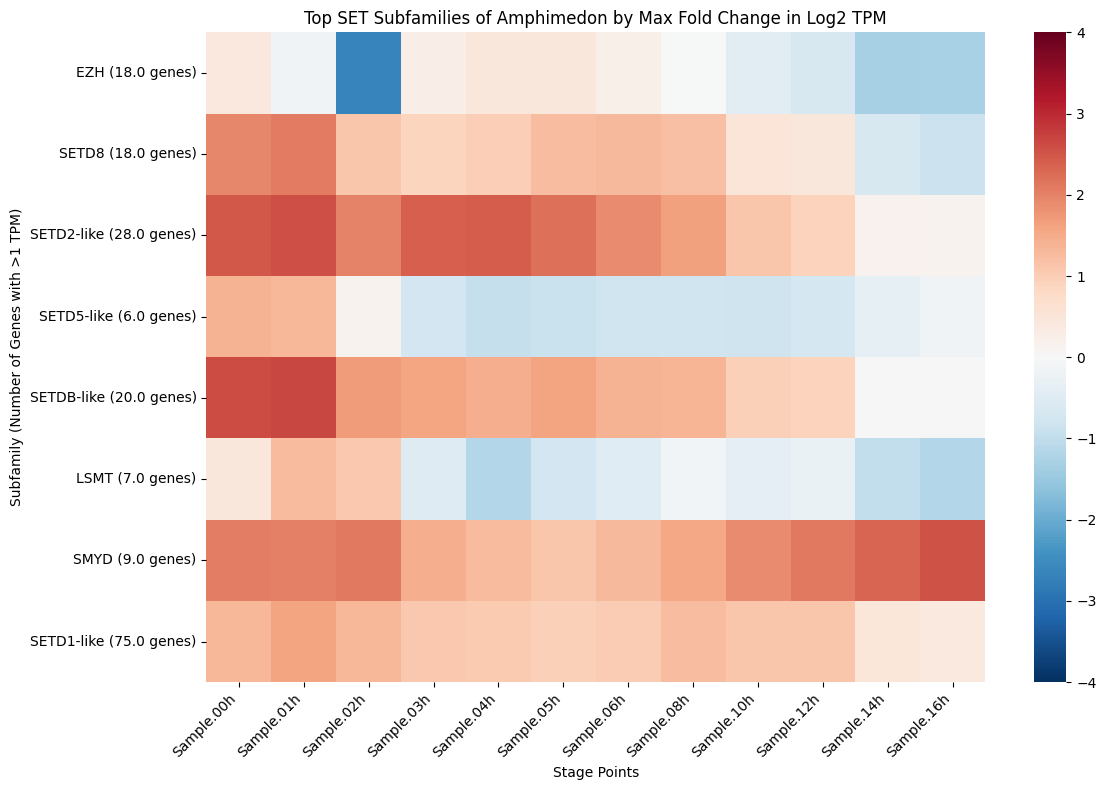

<Figure size 640x480 with 0 Axes>

In [114]:

tpm_columns = [col for col in df_summed.columns if col.startswith('Sample.')]
df_summed['Max_Fold_Change'] = df_summed[tpm_columns].max(axis=1) / (df_summed[tpm_columns].min(axis=1) + 0.5)

#sort based on df_summed["Max_Fold_Change"]
df_sortMX = df_summed.sort_values(by='Max_Fold_Change', ascending=False)
gene_counts = finals_df[finals_df[tpm_columns].gt(1).all(axis=1)].groupby('Subfamily_Name').size().reset_index(name='Gene_Count')
gene_counts = gene_counts[gene_counts['Gene_Count'] > 0]
#merge gene counts
df_summed_W_genecount =df_sortMX.merge(gene_counts, on='Subfamily_Name', how='left')
#drop na
df_summed_W_genecount = df_summed_W_genecount.dropna(subset=['Gene_Count']) 
#print(df_summed_W_genecount)

top_20_superfamilies = df_summed_W_genecount.head(20)

heatmap_data = top_20_superfamilies.set_index('Subfamily_Name')[tpm_columns]
#print(heatmap_data.index)
heatmap_data_log2 = np.log2(heatmap_data + 0.5)

min_val = heatmap_data_log2[tpm_columns].min().min()  # Minimum value across all selected columns
max_val = heatmap_data_log2[tpm_columns].max().max()  # Maximum value across all selected columns
midpoint = (min_val + max_val) / 2 
row_mean = heatmap_data_log2.mean(axis=1)
heatmap_data_centered = heatmap_data_log2.sub(midpoint, axis=0)



#heatmap_data_centered["log2_diff"] = heatmap_data_log2["Sample.Cleavage"] - heatmap_data_log2["Sample.Free.swimming.larvae"]
#print(heatmap_data_centered)
#heatmap_data_sorted = heatmap_data_centered.sort_values(by="log2_diff", ascending=False)
#print(heatmap_data_sorted)
heatmap_data_sorted=heatmap_data_centered
heatmap_data_sorted['Log2_Variance'] = heatmap_data_log2.var(axis=1)
df_summed_W_genecount['Log2_Variance'] = heatmap_data_log2.var(axis=1)
df_summed_W_genecount = df_summed_W_genecount.sort_values(by="Log2_Variance", ascending=False)
top_20_superfamilies = df_summed_W_genecount.head(20)
#heatmap_data_sorted = heatmap_data_sorted.drop("log2_diff", axis=1)
heatmap_data_sorted = heatmap_data_sorted.sort_values(by="Log2_Variance", ascending=False)
#print(heatmap_data_sorted)
heatmap_data_sorted = heatmap_data_sorted.drop("Log2_Variance", axis=1)
row_labels = [f"{superfamily} ({count} genes)"
    for superfamily, count in zip(top_20_superfamilies['Subfamily_Name'], top_20_superfamilies['Gene_Count'])
]
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data_sorted,
    cmap="RdBu_r",
    yticklabels=row_labels,
    vmin=-4,
    vmax=4,
)

plt.title('Top SET Subfamilies of Amphimedon by Max Fold Change in Log2 TPM')
plt.xlabel('Stage Points')
plt.ylabel('Subfamily (Number of Genes with >1 TPM)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.draw()
plt.draw()
plt.show()
plt.savefig('Top Domains Heatmap- drosophila.pdf')



In [115]:
print("heatmap_data_sorted index:")
print(heatmap_data_sorted.index[:5])

print("\ntop_20_superfamilies index:")
print(top_20_superfamilies.index[:5])

heatmap_data_sorted index:
Index(['EZH', 'SETD8', 'SETDB-like', 'LSMT', 'SETD2-like'], dtype='object', name='Subfamily_Name')

top_20_superfamilies index:
Index([1, 2, 3, 4, 5], dtype='int64')


In [116]:
print(heatmap_data_sorted)

                Sample.00h  Sample.01h  Sample.02h  Sample.03h  Sample.04h  \
Subfamily_Name                                                               
EZH               0.420072   -0.162374   -2.685219    0.255336    0.450796   
SETD8             1.961927    2.079685    1.116078    0.882847    0.991732   
SETDB-like        2.474251    2.571753    1.995955    2.390937    2.432763   
LSMT              1.380848    1.336914    0.126833   -0.726451   -0.946941   
SETD2-like        2.620162    2.685219    1.699734    1.590750    1.441745   
SETD5-like        0.455720    1.278501    1.064416   -0.512448   -1.170667   
SMYD              2.034533    2.025558    2.094734    1.461380    1.279422   
SETD1-like        1.313569    1.606183    1.324791    1.088666    1.053418   

                Sample.05h  Sample.06h  Sample.08h  Sample.10h  Sample.12h  \
Subfamily_Name                                                               
EZH               0.463426    0.247441   -0.015719   -0.466629 